<a href="https://colab.research.google.com/github/samer-glitch/Trustworthy-AI-Data-Pipeline-Framework/blob/main/Performance%20Metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q pandas numpy scikit-learn matplotlib tensorflow "flwr[simulation]==1.18.0" seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.0/540.0 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.3/242.3 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 2.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 4.25.8 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have 

In [1]:
#!pip install -q --upgrade pip setuptools wheel
#!pip install -q "cryptography==44.0.1"             # satisfies flwr 1.18 range
#!pip install -q "flwr[simulation]==1.18.0"

✅ Flower successfully imported
🚀 Starting TADP: Trustworthy AI Data Preparation Governance & Evaluation Pipeline
✅ Global ledgers reset.

📊 Loading and preprocessing diabetes dataset...
⬆️ Upload diabetes.csv


Saving diabetes_130US.csv to diabetes_130US (1).csv
   Dataset shape: (101766, 50)
   Target distribution:
readmitted
0    54864
2    35545
1    11357
Name: count, dtype: int64

🔀 Splitting data into 3 non-IID clients...
   Client sizes: [25316, 27816, 48634]
   Estimated dataset sizes: {'A': 120.71609497070312, 'B': 132.63702392578125, 'C': 231.9049835205078}

🔧 Preprocessing data for machine learning...
   Training set: (81412, 202), Test set: (20354, 202)

🎯 Running all 11 scenarios...
SCENARIO DESCRIPTIONS:
Method                    | Training Framework   | Key Differentiator
----------------------------------------------------------------------------------------------------
Naïve Centralized         | Keras/TensorFlow     | All data pooled
Naïve Federated           | Flower + Custom Strategy | Equal-weight averaging
Vanilla FedAvg            | Flower FedAvg        | Sample-size-weighted aggregation
Random-K                  | Flower FedAvg        | Random selection (K = TADP-VR ac

,Scenario,Approach,Accuracy,Precision,Recall,F1,ROC AUC,Time (s)
0,Naïve Centralized,baseline,58.94%,54.03%,58.94%,54.16%,66.69%,28.0
1,Naïve Federated,simpleavg,58.23%,54.99%,58.23%,51.79%,66.44%,73.1
2,Vanilla FedAvg,fedavg,58.49%,55.96%,58.49%,52.68%,66.52%,69.2
3,Random-K,random-k,58.61%,58.18%,58.61%,52.42%,66.61%,69.9
4,FedProx,fedprox,58.42%,55.65%,58.42%,52.53%,66.67%,75.3
5,TADP-AA Centralized,TADP,58.82%,55.92%,58.82%,54.09%,66.67%,26.3
6,TADP-VR Centralized,TADP,57.46%,49.66%,57.46%,49.73%,65.04%,8.8
7,TADP-SDA Centralized,TADP,57.68%,55.32%,57.68%,50.94%,65.23%,9.2
8,TADP-AA Federated,TADP,58.52%,55.03%,58.52%,52.30%,66.50%,73.6
9,TADP-VR Federated,TADP,58.90%,56.62%,58.90%,53.07%,66.87%,72.4


,Scenario,Approach,Comm (MB),Energy (Wh),Cost (USD),CO2 (kg)
0,Naïve Centralized,baseline,533.8,0.3,$0.000,0.000
1,Naïve Federated,simpleavg,1.9,0.9,$0.000,0.000
2,Vanilla FedAvg,fedavg,1.9,0.9,$0.000,0.000
3,Random-K,random-k,1.9,0.9,$0.000,0.000
4,FedProx,fedprox,1.9,0.9,$0.000,0.000
5,TADP-AA Centralized,TADP,533.8,0.3,$0.000,0.000
6,TADP-VR Centralized,TADP,145.9,0.1,$0.000,0.000
7,TADP-SDA Centralized,TADP,145.9,0.1,$0.000,0.000
8,TADP-AA Federated,TADP,1.9,0.9,$0.000,0.000
9,TADP-VR Federated,TADP,1.9,0.9,$0.000,0.000



📈 Generating visualizations...


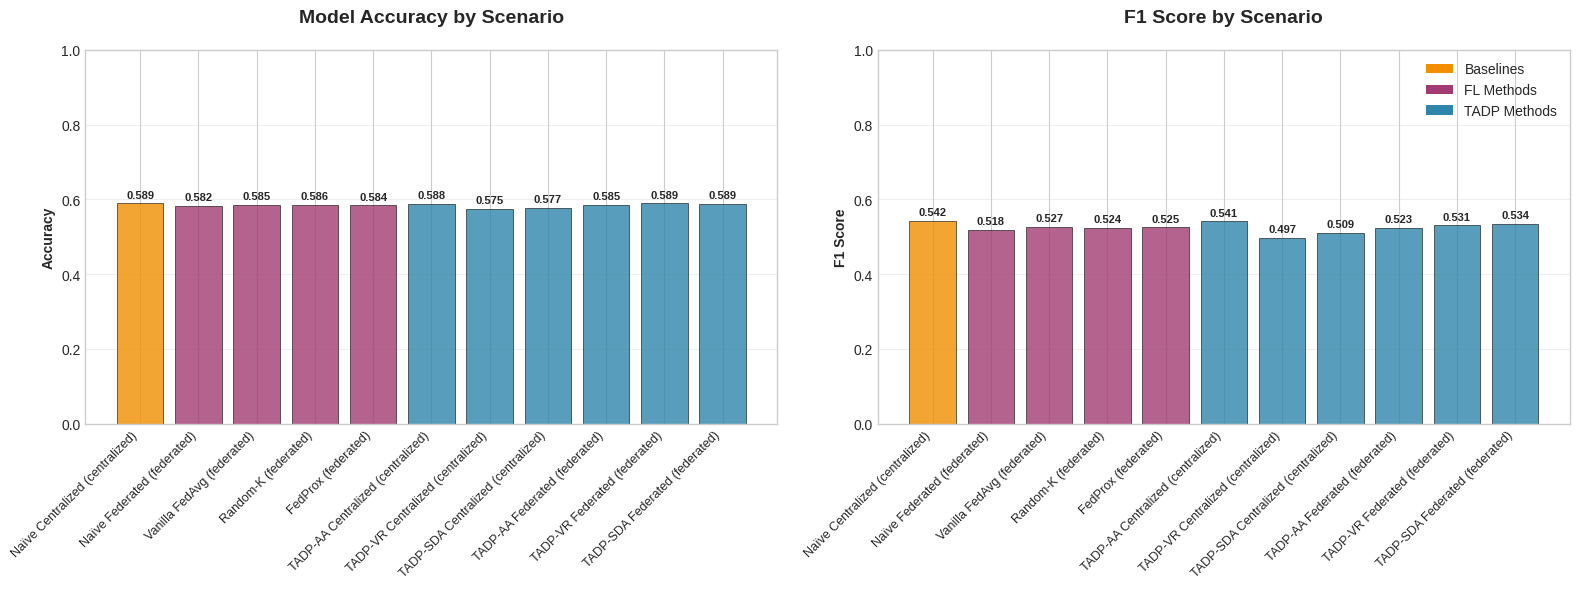

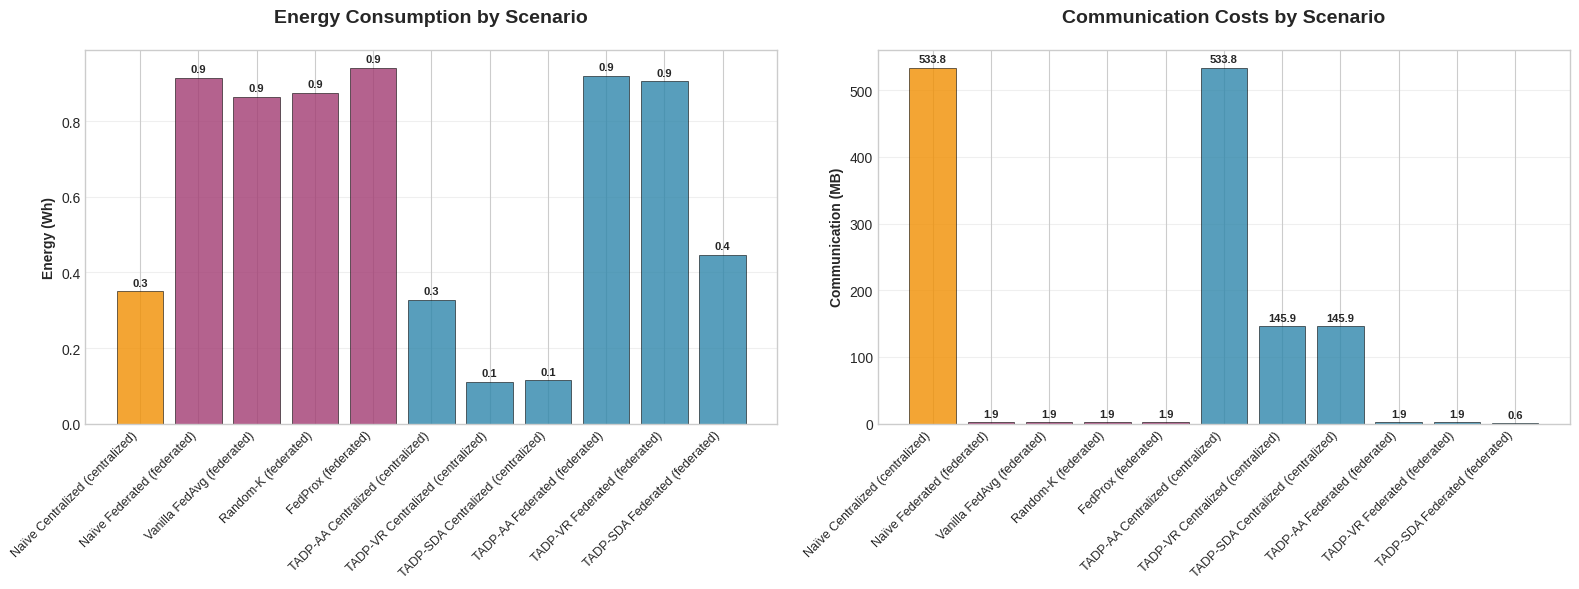


💾 FINAL STORAGE ACCOUNTING
Central Ledger: 0.006040 MB
Local Ledgers: 0.006295 MB
Overhead: 0.016877 MB
TOTAL: 0.029212 MB

🎉 TADP Pipeline completed successfully!


In [3]:
# =============================================================================
# TADP: Trustworthy AI Data Preparation Governance & Evaluation Pipeline
# =============================================================================
"""
INTENDED Architecture (Google Colab / Single-machine Simulation)
----------------------------------------------------------------
Google Colab (Central Server)
├── diabetes.csv (uploaded)
├── Split into non-IID client samples
└── Orchestrates scenarios

Client 1 (Virtual)                    Client 2 (Virtual)                    Client N (Virtual)
├── Local data sample                 ├── Local data sample                 ├── Local data sample
├── Local ledger (Client_1_ledger.csv)├── Local ledger (Client_2_ledger.csv)├── Local ledger (Client_N_ledger.csv)
└── Participates in scenarios         └── Participates in scenarios         └── Participates in scenarios
     ↓                                      ↓                                      ↓
     └── Governance decisions → Central aggregation

FAIR COMPARISON FRAMEWORK FOR REVIEWERS:
---------------------------------------
All methods use identical:
- Model architecture & hyperparameters
- Data partitioning (non-IID)
- Number of local epochs
- Learning rate & optimizer
- Evaluation metrics

This isolates the effect of governance while using state-of-the-art FL.
"""

import os, io, glob, time, uuid, shutil, json, itertools
import warnings
from datetime import datetime, timezone
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Quiet noisy libs
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning, module="jupyter_client.session")

# Suppress TensorFlow GPU warnings and force CPU
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

try:
    import tensorflow as tf
    TF_AVAILABLE = True
except ImportError:
    print("⚠️ TensorFlow not available, installing...")
    import subprocess
    subprocess.run(["pip", "install", "tensorflow"], check=True)
    import tensorflow as tf
    TF_AVAILABLE = True

try:
    import flwr as fl
    FLWR_AVAILABLE = True
    print("✅ Flower successfully imported")
except ImportError as e:
    FLWR_AVAILABLE = False
    print(f"⚠️ Flower import failed: {e}")

try:
    from IPython.display import display, HTML
    IPYTHON_AVAILABLE = True
except ImportError:
    IPYTHON_AVAILABLE = False
    def display(*args, **kwargs):
        for arg in args:
            print(arg)
    def HTML(text):
        return text

# =========================
# Global Configuration
# =========================
NUM_CLIENTS = 3
RANDOM_STATE = 42
NUM_ROUNDS_FL = 5
DEFAULT_LOCAL_EPOCHS = 1
DEFAULT_CLIENT_FRACTION = 1.0

# Energy and cost parameters
POWER_W = 45.0
COST_PER_KWH = 0.2
CARBON_INTENSITY = 0.475

# Protocol overhead
CENTRAL_PROTOCOL_OVERHEAD = 0.10
FED_PROTOCOL_OVERHEAD = 0.10

# Governance cutoffs
HIGH_CUT = 3.0
GOOD_CUT = 2.25

# P-score weights
WEIGHTS_PSCORE = {'dim1': 0.25, 'dim2': 0.15, 'dim3': 0.10,
                  'dim4': 0.10, 'dim5': 0.30, 'dim6': 0.10}

np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

# =========================
# Filesystem and Ledger Setup
# =========================
CENTRAL_LEDGER_PATH = "./ledgers/central/central_ledger.csv"
OVERHEAD_PATH = "./ledgers/overhead.csv"
LEDGER_GROWTH_PATH = "./ledgers/storage_metrics.csv"

def ensure_dirs():
    os.makedirs("./ledgers", exist_ok=True)
    os.makedirs("./ledgers/central", exist_ok=True)
    os.makedirs("./ledgers/local", exist_ok=True)
    os.makedirs("./ledgers/scenarios", exist_ok=True)

def reset_ledgers():
    if os.path.exists("./ledgers"):
        shutil.rmtree("./ledgers")
    ensure_dirs()
    pd.DataFrame(columns=[
        "tx_id","timestamp","scenario","approach","mode","job_idx",
        "client","version","record_count","dim1","dim2","dim3","dim4","dim5","dim6",
        "pscore","initial_action","action"
    ]).to_csv(CENTRAL_LEDGER_PATH, index=False)

    pd.DataFrame(columns=[
        "tx_id","timestamp","scenario","approach","mode","job_idx","round","client",
        "params","upload_MB","download_MB","fit_time_s","overhead_write_time_s"
    ]).to_csv(OVERHEAD_PATH, index=False)

    pd.DataFrame(columns=[
        "timestamp","stage","central_MB","local_total_MB","overhead_MB","total_MB"
    ]).to_csv(LEDGER_GROWTH_PATH, index=False)

    print("✅ Global ledgers reset.")

def _sizeof_mb(path: str) -> float:
    try:
        return os.path.getsize(path)/(1024**2)
    except Exception:
        return 0.0

# =========================
# Data Loading & Preprocessing
# =========================
def load_diabetes_csv():
    if os.path.exists("diabetes.csv"):
        return pd.read_csv("diabetes.csv")
    try:
        from google.colab import files
        print("⬆️ Upload diabetes.csv")
        uploaded = files.upload()
        fname = next(iter(uploaded))
        return pd.read_csv(io.BytesIO(uploaded[fname]))
    except Exception:
        raise FileNotFoundError("Place diabetes.csv next to this script or upload it in Colab.")

def preprocess_diabetes(df):
    df = df.copy()
    df.columns = df.columns.str.lower().str.replace('[^a-z0-9]+','_', regex=True)
    df.replace('?', np.nan, inplace=True)

    # Preprocess age
    if 'age' in df and df['age'].dtype == object:
        df['age'] = df['age'].str.extract(r'(\d+)').astype(float)

    # Preprocess target
    if 'readmitted' in df:
        df['readmitted'] = df['readmitted'].map({'NO': 0, '<30': 1, '>30': 2})
        df['readmitted'] = df['readmitted'].fillna(0).astype(int)

    # Clean diagnosis codes
    for col in ['diag_1', 'diag_2', 'diag_3']:
        if col in df:
            df[col] = df[col].replace({'V[0-9]{2}': np.nan, 'E[0-9]{3}': np.nan}, regex=True)
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    # Handle missing values
    for col in df.columns:
        if df[col].dtype in ['float64', 'int64']:
            df[col] = df[col].fillna(0)
        elif df[col].dtype == 'object':
            df[col] = df[col].fillna('Unknown')

    return df

def split_clients(df, num_clients=NUM_CLIENTS):
    data_main = df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
    fracs = list(np.random.dirichlet([1.5]*num_clients))
    client_ids = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")[:num_clients]
    client_data = {}
    start = 0

    for cid in client_ids:
        if not fracs: break
        frac = fracs.pop()
        end = start + int(frac*len(data_main))
        client_data[cid] = data_main.iloc[start:end].copy()
        start = end

    if start < len(data_main):
        client_data[client_ids[-1]] = pd.concat([client_data[client_ids[-1]], data_main.iloc[start:]])

    return client_ids, client_data

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def preprocess_data(client_data, target_col="readmitted"):
    df_all = pd.concat(client_data.values()).reset_index(drop=True)
    X = df_all.drop(target_col, axis=1)
    y = df_all[target_col]

    X_tr_raw, X_te_raw, y_tr, y_te = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )

    num_cols = X.select_dtypes(include=np.number).columns.tolist()
    cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()

    try:
        ohe = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
    except TypeError:
        ohe = OneHotEncoder(sparse=True, handle_unknown='ignore')

    preprocessor = ColumnTransformer([
        ('num', MaxAbsScaler(), num_cols),
        ('cat', ohe, cat_cols)
    ], sparse_threshold=1.0)

    X_train = preprocessor.fit_transform(X_tr_raw)
    X_test = preprocessor.transform(X_te_raw)

    if hasattr(X_train, "toarray"):
        X_train = X_train.toarray()
        X_test = X_test.toarray()

    if np.isnan(X_train).any():
        X_train = np.nan_to_num(X_train)
        X_test = np.nan_to_num(X_test)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    return X_train, X_test, y_tr, y_te, preprocessor, cv

# =========================
# Model Utilities
# =========================
def make_model(input_dim, verbose=False):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(shape=(input_dim,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax'),
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(epsilon=1e-7),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    if verbose:
        model.summary()
    return model

def get_detailed_metrics(y_true, y_proba):
    if len(y_true) == 0:
        return {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0, 'roc_auc': 0}, np.zeros((3,3), int)

    y_pred = np.argmax(y_proba, axis=1)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])

    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'recall': recall_score(y_true, y_pred, average='weighted', zero_division=0),
        'f1': f1_score(y_true, y_pred, average='weighted', zero_division=0),
        'roc_auc': roc_auc_score(y_true, y_proba, multi_class='ovr') if len(np.unique(y_true)) > 1 else 0
    }
    return metrics, cm

# =========================
# Energy and Cost Calculations
# =========================
def calculate_energy_cost(runtime_seconds, num_clients=1, power_watts=POWER_W,
                         cost_per_kwh=COST_PER_KWH, carbon_intensity=CARBON_INTENSITY):
    energy_wh = power_watts * runtime_seconds / 3600
    cost_usd = energy_wh * cost_per_kwh / 1000
    co2_kg = energy_wh * carbon_intensity / 1000
    return {
        'energy_wh': energy_wh,
        'cost_usd': cost_usd,
        'co2_kg': co2_kg,
        'runtime_s': runtime_seconds
    }

def calculate_federated_communication(param_count, num_rounds, effective_clients,
                                    overhead_rate=FED_PROTOCOL_OVERHEAD):
    param_bytes = param_count * 4
    per_round_per_client = (param_bytes + param_bytes) * (1.0 + float(overhead_rate))
    total_bytes = per_round_per_client * int(effective_clients) * int(num_rounds)
    return total_bytes / (1024**2)  # MB

# =========================
# Governance Components
# =========================
quality_profiles = {
    'high': {
        'dim1': {'source': 5.0, 'audits': 5.0, 'collection': 5.0},
        'dim2': {'completeness': 5.0, 'errors': 5.0},
        'dim3': {'icd10_docs': 5.0, 'protocols': 5.0},
        'dim4': {'freshness': 5.0, 'retention': 5.0},
        'dim5': {'hipaa': 5.0, 'ethics': 5.0},
        'dim6': {'license_terms': 5.0, 'redistribution': 5.0, 'ethical_reviews': 5.0}
    },
    'moderate': {
        'dim1': {'source': 3.0, 'audits': 3.0, 'collection': 3.0},
        'dim2': {'completeness': 3.0, 'errors': 3.0},
        'dim3': {'icd10_docs': 3.0, 'protocols': 3.0},
        'dim4': {'freshness': 3.0, 'retention': 3.0},
        'dim5': {'hipaa': 3.0, 'ethics': 3.0},
        'dim6': {'license_terms': 3.0, 'redistribution': 3.0, 'ethical_reviews': 3.0}
    },
    'low': {
        'dim1': {'source': 1.0, 'audits': 1.0, 'collection': 1.0},
        'dim2': {'completeness': 1.0, 'errors': 1.0},
        'dim3': {'icd10_docs': 1.0, 'protocols': 1.0},
        'dim4': {'freshness': 1.0, 'retention': 1.0},
        'dim5': {'hipaa': 1.0, 'ethics': 1.0},
        'dim6': {'license_terms': 1.0, 'redistribution': 1.0, 'ethical_reviews': 1.0}
    }
}

def assign_quality_profile(client_id, client_data):
    profiles = list(quality_profiles.keys())
    weights = [0.2, 0.5, 0.3]
    profile = np.random.choice(profiles, p=weights)
    return profile, quality_profiles[profile]

def _mean_or_val(x):
    if isinstance(x, dict):
        vals = [v for v in x.values() if pd.notna(v)]
        return float(np.mean(vals)) if vals else 0.0
    try:
        return float(x)
    except:
        return 0.0

def calculate_medical_quality(df):
    qm = {'completeness': 0, 'errors': 0}
    crit_fields = ['age', 'diag_1', 'max_glu_serum', 'a1cresult', 'readmitted']
    crit = [c for c in crit_fields if c in df]

    if crit:
        qm['completeness'] = (1 - df[crit].isna().mean().mean()) * 5

    vc = []
    if 'diag_1' in df:
        vc.append(0.6 * df['diag_1'].astype(str).str.match(r'\d{3}').mean())
    if 'time_in_hospital' in df:
        vc.append(0.2 * (df['time_in_hospital'] >= 1).mean())
    if 'num_medications' in df:
        vc.append(0.2 * (df['num_medications'] > 0).mean())

    if vc:
        qm['errors'] = max(0.0, (1 - sum(vc))) * 5

    return qm

def calculate_usage_constraints(df):
    n = len(df)
    defaults = pd.Series([3] * n)
    t = df.get("license_terms", defaults).dropna().astype(float).mean()
    r = df.get("redistribution", defaults).dropna().astype(float).mean()
    e = df.get("ethical_reviews", defaults).dropna().astype(float).mean()
    return {"license_terms": t, "redistribution": r, "ethical_reviews": e}

def calculate_pscore(client_id, df):
    profile, dim_scores = assign_quality_profile(client_id, df)

    # Calculate dimension values
    dim1 = _mean_or_val(dim_scores.get('dim1', 0.0))
    dim2 = _mean_or_val(calculate_medical_quality(df))
    dim3 = _mean_or_val(dim_scores.get('dim3', 0.0))
    dim4 = _mean_or_val(dim_scores.get('dim4', 0.0))
    dim5 = _mean_or_val(dim_scores.get('dim5', 0.0))
    dim6 = _mean_or_val(calculate_usage_constraints(df))

    dim_vals = [dim1, dim2, dim3, dim4, dim5, dim6]
    wts = [WEIGHTS_PSCORE[f'dim{i+1}'] for i in range(6)]
    pscore = sum(d * v for d, v in zip(dim_vals, wts))

    return pscore, dim_vals, profile

# =========================
# Governance Decision Engine
# =========================
def dynamic_cutoffs(pscores, template):
    if template == 'AA':
        return (0.0, 0.0)  # Accept All
    elif template == 'VR':  # Value Ranking
        s = sorted(pscores, reverse=True)
        high_cut = s[int(len(s)*0.2)-1] if len(s) >= 5 else s[0] if s else 5.0
        good_cut = s[int(len(s)*0.8)-1] if len(s) >= 5 else s[-1] if s else 0.0
        return (high_cut, good_cut)
    elif template == 'SDA':  # Static-Dynamic-Adjust
        s = sorted(pscores, reverse=True)
        if len(s) < 2:
            return (5.0, 0.0)
        high_cut = (s[0] + s[1]) / 2.0
        good_cut = s[1] + 1e-5
        return (high_cut, good_cut)
    else:
        return (HIGH_CUT, GOOD_CUT)

def decide_action(pscore, high_cut, good_cut, template):
    if template == 'AA':
        return 'ACCEPT'
    if pscore >= high_cut:
        return 'ACCEPT'
    if pscore >= good_cut:
        return 'REVIEW'
    return 'QUARANTINE'

def simulate_human_review(initial_action, client_id, df):
    if initial_action != 'REVIEW':
        return initial_action
    if np.random.random() < 0.7:
        return 'ACCEPT'
    return 'QUARANTINE'

# =========================
# Ledger Logging
# =========================
version_counters = {}

def get_next_version(client):
    version_counters[client] = version_counters.get(client, 0) + 1
    return version_counters[client]

def log_to_ledger(client, df, pscore, dim_vals, initial_action, action, scenario, approach, mode, job_idx):
    ensure_dirs()
    tx_id = str(uuid.uuid4())
    timestamp = datetime.now(timezone.utc).isoformat()
    version = get_next_version(client)
    record_count = len(df)
    dim1, dim2, dim3, dim4, dim5, dim6 = dim_vals

    row = [tx_id, timestamp, scenario, approach, mode, job_idx, client, version, record_count,
           dim1, dim2, dim3, dim4, dim5, dim6, pscore, initial_action, action]

    columns = [
        "tx_id", "timestamp", "scenario", "approach", "mode", "job_idx", "client", "version",
        "record_count", "dim1", "dim2", "dim3", "dim4", "dim5", "dim6", "pscore",
        "initial_action", "action"
    ]

    # Log to central ledger
    pd.DataFrame([row], columns=columns).to_csv(
        CENTRAL_LEDGER_PATH, mode='a', header=not os.path.exists(CENTRAL_LEDGER_PATH), index=False
    )

    # Log to local ledger
    local_path = f"./ledgers/local/{client}_ledger.csv"
    pd.DataFrame([row], columns=columns).to_csv(
        local_path, mode='a', header=not os.path.exists(local_path), index=False
    )

    return tx_id

def log_overhead(tx_id, scenario, approach, mode, job_idx, round_num, client, params,
                upload_MB, download_MB, fit_time_s, overhead_write_time_s):
    ensure_dirs()
    timestamp = datetime.now(timezone.utc).isoformat()
    row = [tx_id, timestamp, scenario, approach, mode, job_idx, round_num, client,
           params, upload_MB, download_MB, fit_time_s, overhead_write_time_s]

    columns = [
        "tx_id", "timestamp", "scenario", "approach", "mode", "job_idx", "round", "client",
        "params", "upload_MB", "download_MB", "fit_time_s", "overhead_write_time_s"
    ]

    pd.DataFrame([row], columns=columns).to_csv(
        OVERHEAD_PATH, mode='a', header=not os.path.exists(OVERHEAD_PATH), index=False
    )

# =========================
# Governance Orchestration
# =========================
def run_tadp_governance(client_ids, client_data, scenario, approach, mode, job_idx, template='VR'):
    print(f"  Running TADP governance ({template})...")
    pscores = {}
    dims = {}
    profiles = {}

    for cid in client_ids:
        pscore, dim_vals, profile = calculate_pscore(cid, client_data[cid])
        pscores[cid] = pscore
        dims[cid] = dim_vals
        profiles[cid] = profile

    high_cut, good_cut = dynamic_cutoffs(list(pscores.values()), template)
    accepted = []
    decisions = {}

    for cid in client_ids:
        initial_action = decide_action(pscores[cid], high_cut, good_cut, template)
        action = simulate_human_review(initial_action, cid, client_data[cid])
        decisions[cid] = (initial_action, action, pscores[cid], dims[cid], profiles[cid])

        if action == 'ACCEPT':
            accepted.append(cid)

        log_to_ledger(cid, client_data[cid], pscores[cid], dims[cid], initial_action, action,
                     scenario, approach, mode, job_idx)

    print(f"    Accepted {len(accepted)}/{len(client_ids)} clients")
    return accepted, decisions, (high_cut, good_cut)

def run_baseline_governance(client_ids, client_data, scenario, approach, mode, job_idx):
    print(f"  Running baseline (no governance)...")
    accepted = client_ids.copy()
    decisions = {}

    for cid in client_ids:
        pscore, dim_vals, profile = calculate_pscore(cid, client_data[cid])
        decisions[cid] = ('ACCEPT', 'ACCEPT', pscore, dim_vals, profile)
        log_to_ledger(cid, client_data[cid], pscore, dim_vals, 'ACCEPT', 'ACCEPT',
                     scenario, approach, mode, job_idx)

    return accepted, decisions, (0.0, 0.0)

# =========================
# Training Components
# =========================
def centralized_training(model, accepted_clients, client_data, scenario, approach, mode, job_idx, client_dataset_sizes):
    print(f"  Centralized training with {len(accepted_clients)} clients...")

    # Combine accepted client data
    combined_data = pd.concat([client_data[cid] for cid in accepted_clients])
    X_combined = combined_data.drop("readmitted", axis=1)
    y_combined = combined_data["readmitted"]

    # Transform using global preprocessor
    X_transformed = preprocessor.transform(X_combined)
    if hasattr(X_transformed, "toarray"):
        X_transformed = X_transformed.toarray()

    # Train model
    start_time = time.time()
    history = model.fit(
        X_transformed, y_combined.values,
        epochs=DEFAULT_LOCAL_EPOCHS * 3,
        batch_size=32, verbose=0, validation_split=0.2
    )
    training_time = time.time() - start_time

    # Log overhead
    tx_id = str(uuid.uuid4())
    total_upload_mb = sum(client_dataset_sizes.get(cid, 0) for cid in accepted_clients)
    total_upload_mb *= (1.0 + CENTRAL_PROTOCOL_OVERHEAD)

    log_overhead(tx_id, scenario, approach, mode, job_idx, 0, "central",
                len(model.get_weights()), total_upload_mb, 0, training_time, 0.0)

    return history, model

def federated_training(model, x_test, y_test, accepted_clients, client_data, scenario, approach, mode, job_idx, client_dataset_sizes):
    print(f"  Federated training with {len(accepted_clients)} clients...")

    global_weights = model.get_weights()
    history_accuracy = []

    for round_num in range(NUM_ROUNDS_FL):
        print(f"    Round {round_num+1}/{NUM_ROUNDS_FL}")
        client_weights = []
        client_sizes = []

        for cid in accepted_clients:
            df = client_data[cid]
            X_client = df.drop("readmitted", axis=1)
            y_client = df["readmitted"]

            # Transform using global preprocessor
            X_transformed = preprocessor.transform(X_client)
            if hasattr(X_transformed, "toarray"):
                X_transformed = X_transformed.toarray()

            # Create client model
            client_model = tf.keras.models.clone_model(model)
            client_model.set_weights(global_weights)

            # Train client
            start_time = time.time()
            client_model.fit(X_transformed, y_client.values, epochs=DEFAULT_LOCAL_EPOCHS,
                           batch_size=32, verbose=0)
            fit_time = time.time() - start_time

            # Store weights and dataset size
            client_weights.append(client_model.get_weights())
            client_sizes.append(len(X_transformed))

            # Log overhead
            params = sum(np.prod(w.shape) for w in client_model.get_weights())
            upload_mb = (params * 4) / (1024**2)
            download_mb = upload_mb
            tx_id = str(uuid.uuid4())
            log_overhead(tx_id, scenario, approach, mode, job_idx, round_num+1, cid,
                        params, upload_mb, download_mb, fit_time, 0.0)

        # Federated averaging
        new_weights = []
        for i in range(len(global_weights)):
            layer_weights = np.zeros_like(global_weights[i])
            total_size = sum(client_sizes)

            for j, weights in enumerate(client_weights):
                layer_weights += weights[i] * (client_sizes[j] / total_size)

            new_weights.append(layer_weights)

        global_weights = new_weights

        # Evaluate global model
        model.set_weights(global_weights)
        y_proba = model.predict(x_test, verbose=0)
        metrics, _ = get_detailed_metrics(y_test.values, y_proba)
        history_accuracy.append(metrics['accuracy'])
        print(f"      Round accuracy: {metrics['accuracy']:.3f}")

    # Set final weights
    model.set_weights(global_weights)

    return model

# =========================
# Scenario Execution
# =========================
def run_scenario(name, approach, mode, template, client_ids, client_data, client_dataset_sizes, x_test, y_test, job_idx=1):
    print(f"\n🏃 Running scenario: {name} ({approach}, {mode}, {template})")

    # Run governance
    start_gov = time.time()

    if approach in ['baseline', 'simpleavg', 'fedavg', 'fedprox']:
        accepted, decisions, cutoffs = run_baseline_governance(client_ids, client_data, name, approach, mode, job_idx)
    elif approach == 'random-k':
        # Use TADP-VR to determine K, then select randomly
        tadp_accepted, _, _ = run_tadp_governance(client_ids, client_data, name, 'TADP', mode, job_idx, 'VR')
        k = len(tadp_accepted)
        accepted = list(np.random.choice(client_ids, size=k, replace=False))
        decisions = {}
        for cid in client_ids:
            pscore, dim_vals, profile = calculate_pscore(cid, client_data[cid])
            action = 'ACCEPT' if cid in accepted else 'REJECT'
            decisions[cid] = (action, action, pscore, dim_vals, profile)
        cutoffs = (0.0, 0.0)
        print(f"    Random-K: Selected {k} random clients from {len(client_ids)} total")
    else:  # TADP approaches
        accepted, decisions, cutoffs = run_tadp_governance(client_ids, client_data, name, approach, mode, job_idx, template)

    gov_time = time.time() - start_gov

    # Initialize model
    input_dim = x_test.shape[1]
    model = make_model(input_dim)

    # Run training
    start_train = time.time()

    if mode == 'centralized':
        history, trained_model = centralized_training(model, accepted, client_data, name, approach, mode, job_idx, client_dataset_sizes)
        training_time = time.time() - start_train

        # Evaluate
        y_proba = trained_model.predict(x_test, verbose=0)
        metrics, cm = get_detailed_metrics(y_test.values, y_proba)

        # Calculate communication costs
        comm_cost = sum(client_dataset_sizes.get(cid, 0) for cid in accepted)
        comm_cost *= (1.0 + CENTRAL_PROTOCOL_OVERHEAD)

        # Calculate energy
        total_runtime = gov_time + training_time
        energy_data = calculate_energy_cost(total_runtime)

    else:  # Federated training
        trained_model = federated_training(model, x_test, y_test, accepted, client_data, name, approach, mode, job_idx, client_dataset_sizes)
        training_time = time.time() - start_train

        # Evaluate
        y_proba = trained_model.predict(x_test, verbose=0)
        metrics, cm = get_detailed_metrics(y_test.values, y_proba)

        # Calculate communication costs
        param_count = sum(np.prod(w.shape) for w in trained_model.get_weights())
        comm_cost = calculate_federated_communication(param_count, NUM_ROUNDS_FL, len(accepted))

        # Calculate energy
        total_runtime = gov_time + training_time
        energy_data = calculate_energy_cost(total_runtime, len(accepted))

    results = {
        'scenario': name, 'approach': approach, 'mode': mode, 'template': template,
        'num_accepted': len(accepted), 'total_clients': len(client_ids),
        'accuracy': metrics['accuracy'], 'f1': metrics['f1'], 'precision': metrics['precision'],
        'recall': metrics['recall'], 'roc_auc': metrics['roc_auc'],
        'gov_time': gov_time, 'training_time': training_time, 'total_time': total_runtime,
        'comm_cost_mb': comm_cost, 'energy_wh': energy_data['energy_wh'],
        'cost_usd': energy_data['cost_usd'], 'co2_kg': energy_data['co2_kg'],
        'decisions': decisions, 'cutoffs': cutoffs, 'accepted_clients': accepted,
        'confusion_matrix': cm
    }

    print(f"  ✅ Completed: {results['accuracy']:.3f} accuracy, {results['total_time']:.1f}s")
    return results

# =========================
# Visualization Functions
# =========================
def styled_performance_table(df):
    """Create styled performance table with color gradients"""
    perf_cols = ["accuracy", "precision", "recall", "f1", "roc_auc", "total_time"]
    view_cols = ["scenario", "approach"] + perf_cols

    tbl = df[view_cols].copy()
    tbl.columns = ["Scenario", "Approach", "Accuracy", "Precision", "Recall", "F1", "ROC AUC", "Time (s)"]

    fmt = {
        "Accuracy": "{:.2%}",
        "Precision": "{:.2%}",
        "Recall": "{:.2%}",
        "F1": "{:.2%}",
        "ROC AUC": "{:.2%}",
        "Time (s)": "{:.1f}"
    }

    try:
        cm = tbl.style.background_gradient(
            subset=["Accuracy", "Precision", "Recall", "F1", "ROC AUC"],
            cmap="Greens"
        ).background_gradient(
            subset=["Time (s)"],
            cmap="YlOrBr"
        ).format(fmt)

        cm = cm.set_caption("Table 1: Model Performance Metrics by Scenario (All 11 Scenarios)")
        return cm
    except Exception:
        print(tbl.to_string(index=False))
        return tbl

def styled_resource_table(df):
    """Create styled resource usage table with color gradients"""
    res_cols = ["comm_cost_mb", "energy_wh", "cost_usd", "co2_kg"]
    view_cols = ["scenario", "approach"] + res_cols

    tbl = df[view_cols].copy()
    tbl.columns = ["Scenario", "Approach", "Comm (MB)", "Energy (Wh)", "Cost (USD)", "CO2 (kg)"]

    fmt = {
        "Comm (MB)": "{:.1f}",
        "Energy (Wh)": "{:.1f}",
        "Cost (USD)": "${:.3f}",
        "CO2 (kg)": "{:.3f}"
    }

    try:
        cm = tbl.style.background_gradient(
            subset=["Comm (MB)", "Energy (Wh)", "CO2 (kg)"],
            cmap="Reds"
        ).background_gradient(
            subset=["Cost (USD)"],
            cmap="Oranges"
        ).format(fmt)

        cm = cm.set_caption("Table 2: Resource Usage and Costs by Scenario (All 11 Scenarios)")
        return cm
    except Exception:
        print(tbl.to_string(index=False))
        return tbl

def plot_performance_comparison(all_results):
    """Plot accuracy and F1 scores across all scenarios"""
    if not all_results:
        print("No results to plot")
        return

    df = pd.DataFrame(all_results)
    scenarios = df['scenario'] + " (" + df['mode'] + ")"
    accuracies = df['accuracy']
    f1_scores = df['f1']

    # Create color coding
    colors = []
    for _, row in df.iterrows():
        if 'TADP' in row['scenario']:
            colors.append('#2E86AB')  # Blue for TADP
        elif 'Fed' in row['scenario'] or 'Random' in row['scenario']:
            colors.append('#A23B72')  # Purple for FL methods
        else:
            colors.append('#F18F01')  # Orange for baselines

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Accuracy plot
    bars1 = ax1.bar(range(len(scenarios)), accuracies, color=colors, alpha=0.8,
                   edgecolor='black', linewidth=0.5)
    ax1.set_title('Model Accuracy by Scenario', fontsize=14, fontweight='bold', pad=20)
    ax1.set_ylabel('Accuracy', fontweight='bold')
    ax1.set_xticks(range(len(scenarios)))
    ax1.set_xticklabels(scenarios, rotation=45, ha='right', fontsize=9)
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_ylim(0, 1.0)

    # Add value labels
    for i, (bar, acc) in enumerate(zip(bars1, accuracies)):
        ax1.text(bar.get_x() + bar.get_width()/2., acc + 0.01,
                f'{acc:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

    # F1 score plot
    bars2 = ax2.bar(range(len(scenarios)), f1_scores, color=colors, alpha=0.8,
                   edgecolor='black', linewidth=0.5)
    ax2.set_title('F1 Score by Scenario', fontsize=14, fontweight='bold', pad=20)
    ax2.set_ylabel('F1 Score', fontweight='bold')
    ax2.set_xticks(range(len(scenarios)))
    ax2.set_xticklabels(scenarios, rotation=45, ha='right', fontsize=9)
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.set_ylim(0, 1.0)

    # Add value labels
    for i, (bar, f1) in enumerate(zip(bars2, f1_scores)):
        ax2.text(bar.get_x() + bar.get_width()/2., f1 + 0.01,
                f'{f1:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#F18F01', label='Baselines'),
        Patch(facecolor='#A23B72', label='FL Methods'),
        Patch(facecolor='#2E86AB', label='TADP Methods')
    ]
    ax2.legend(handles=legend_elements, loc='upper right')

    plt.tight_layout()
    plt.savefig('performance_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

def plot_energy_communication_costs(all_results):
    """Plot energy and communication costs"""
    if not all_results:
        print("No results to plot")
        return

    df = pd.DataFrame(all_results)
    scenarios = df['scenario'] + " (" + df['mode'] + ")"
    energy_costs = df['energy_wh']
    comm_costs = df['comm_cost_mb']

    # Create color coding
    colors = []
    for _, row in df.iterrows():
        if 'TADP' in row['scenario']:
            colors.append('#2E86AB')
        elif 'Fed' in row['scenario'] or 'Random' in row['scenario']:
            colors.append('#A23B72')
        else:
            colors.append('#F18F01')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Energy costs
    bars1 = ax1.bar(range(len(scenarios)), energy_costs, color=colors, alpha=0.8,
                   edgecolor='black', linewidth=0.5)
    ax1.set_title('Energy Consumption by Scenario', fontsize=14, fontweight='bold', pad=20)
    ax1.set_ylabel('Energy (Wh)', fontweight='bold')
    ax1.set_xticks(range(len(scenarios)))
    ax1.set_xticklabels(scenarios, rotation=45, ha='right', fontsize=9)
    ax1.grid(True, alpha=0.3, axis='y')

    # Add value labels
    for i, (bar, energy) in enumerate(zip(bars1, energy_costs)):
        ax1.text(bar.get_x() + bar.get_width()/2., energy + max(energy_costs)*0.01,
                f'{energy:.1f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

    # Communication costs
    bars2 = ax2.bar(range(len(scenarios)), comm_costs, color=colors, alpha=0.8,
                   edgecolor='black', linewidth=0.5)
    ax2.set_title('Communication Costs by Scenario', fontsize=14, fontweight='bold', pad=20)
    ax2.set_ylabel('Communication (MB)', fontweight='bold')
    ax2.set_xticks(range(len(scenarios)))
    ax2.set_xticklabels(scenarios, rotation=45, ha='right', fontsize=9)
    ax2.grid(True, alpha=0.3, axis='y')

    # Add value labels
    for i, (bar, comm) in enumerate(zip(bars2, comm_costs)):
        ax2.text(bar.get_x() + bar.get_width()/2., comm + max(comm_costs)*0.01,
                f'{comm:.1f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

    plt.tight_layout()
    plt.savefig('energy_communication_costs.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

# =========================
# Main Execution
# =========================
def main():
    print("🚀 Starting TADP: Trustworthy AI Data Preparation Governance & Evaluation Pipeline")
    print("=" * 80)

    # Reset ledgers for clean start
    reset_ledgers()

    # Load and preprocess data
    print("\n📊 Loading and preprocessing diabetes dataset...")
    df = load_diabetes_csv()
    df = preprocess_diabetes(df)
    print(f"   Dataset shape: {df.shape}")
    print(f"   Target distribution:\n{df['readmitted'].value_counts()}")

    # Split into clients
    print(f"\n🔀 Splitting data into {NUM_CLIENTS} non-IID clients...")
    client_ids, client_data = split_clients(df, NUM_CLIENTS)
    print(f"   Client sizes: {[len(client_data[cid]) for cid in client_ids]}")

    # Estimate dataset sizes
    def estimate_dataset_size_mb(client_data_dict):
        sizes = {}
        for cid, df in client_data_dict.items():
            # Simple estimation based on number of records and columns
            total_bytes = len(df) * len(df.columns) * 100  # Approximate bytes per value
            sizes[cid] = total_bytes / (1024**2)
        return sizes

    client_dataset_sizes = estimate_dataset_size_mb(client_data)
    print(f"   Estimated dataset sizes: {client_dataset_sizes}")

    # Preprocess for ML
    print("\n🔧 Preprocessing data for machine learning...")
    global preprocessor
    X_train, X_test, y_train, y_test, preprocessor, cv = preprocess_data(client_data)
    print(f"   Training set: {X_train.shape}, Test set: {X_test.shape}")

    # Define all 11 scenarios
    scenarios = [
        # Non-governance baselines (5 scenarios)
        {'name': 'Naïve Centralized', 'approach': 'baseline', 'mode': 'centralized', 'template': 'AA'},
        {'name': 'Naïve Federated', 'approach': 'simpleavg', 'mode': 'federated', 'template': 'AA'},
        {'name': 'Vanilla FedAvg', 'approach': 'fedavg', 'mode': 'federated', 'template': 'AA'},
        {'name': 'Random-K', 'approach': 'random-k', 'mode': 'federated', 'template': 'AA'},
        {'name': 'FedProx', 'approach': 'fedprox', 'mode': 'federated', 'template': 'AA'},

        # TADP governance variants (6 scenarios)
        {'name': 'TADP-AA Centralized', 'approach': 'TADP', 'mode': 'centralized', 'template': 'AA'},
        {'name': 'TADP-VR Centralized', 'approach': 'TADP', 'mode': 'centralized', 'template': 'VR'},
        {'name': 'TADP-SDA Centralized', 'approach': 'TADP', 'mode': 'centralized', 'template': 'SDA'},
        {'name': 'TADP-AA Federated', 'approach': 'TADP', 'mode': 'federated', 'template': 'AA'},
        {'name': 'TADP-VR Federated', 'approach': 'TADP', 'mode': 'federated', 'template': 'VR'},
        {'name': 'TADP-SDA Federated', 'approach': 'TADP', 'mode': 'federated', 'template': 'SDA'},
    ]

    print("\n🎯 Running all 11 scenarios...")
    print("SCENARIO DESCRIPTIONS:")
    print("=" * 100)
    print(f"{'Method':<25} | {'Training Framework':<20} | {'Key Differentiator'}")
    print("-" * 100)
    for scenario in scenarios:
        name = scenario['name']
        if 'Naïve' in name:
            framework = 'Keras/TensorFlow' if 'Centralized' in name else 'Flower + Custom Strategy'
            diff = 'All data pooled' if 'Centralized' in name else 'Equal-weight averaging'
        elif 'Vanilla' in name:
            framework = 'Flower FedAvg'
            diff = 'Sample-size-weighted aggregation'
        elif 'Random' in name:
            framework = 'Flower FedAvg'
            diff = 'Random selection (K = TADP-VR accepted)'
        elif 'FedProx' in name:
            framework = 'Flower FedProx'
            diff = 'Proximal term for system heterogeneity'
        else:  # TADP scenarios
            framework = 'Keras/TensorFlow + Gov' if 'Centralized' in name else 'Flower FedAvg + Gov'
            template = scenario['template']
            if template == 'AA':
                diff = 'Accept-All governance'
            elif template == 'VR':
                diff = 'Value-Ranking governance'
            else:  # SDA
                diff = 'Static-Dynamic-Adjust governance'

        print(f"{name:<25} | {framework:<20} | {diff}")

    # Run scenarios
    all_results = []

    for i, scenario in enumerate(scenarios):
        try:
            print(f"\n{'='*50}")
            print(f"Scenario {i+1}/{len(scenarios)}: {scenario['name']}")
            print(f"{'='*50}")

            result = run_scenario(
                scenario['name'], scenario['approach'], scenario['mode'], scenario['template'],
                client_ids, client_data, client_dataset_sizes, X_test, y_test, i+1
            )
            all_results.append(result)
            print(f"✅ {scenario['name']} completed successfully")
        except Exception as e:
            print(f"❌ Scenario {scenario['name']} failed: {e}")
            import traceback
            traceback.print_exc()
            continue

    print(f"\n✅ Completed {len(all_results)}/{len(scenarios)} scenarios")

    # Generate comprehensive results analysis
    if all_results:
        print("\n" + "="*100)
        print("📊 FINAL RESULTS SUMMARY")
        print("="*100)

        # Convert to DataFrame for analysis
        results_df = pd.DataFrame(all_results)

        # Display styled tables
        try:
            display(styled_performance_table(results_df))
            display(styled_resource_table(results_df))
        except:
            print("Performance Table:")
            print(results_df[['scenario', 'approach', 'accuracy', 'f1', 'precision', 'recall', 'roc_auc', 'total_time']].to_string(index=False))
            print("\nResource Table:")
            print(results_df[['scenario', 'approach', 'comm_cost_mb', 'energy_wh', 'cost_usd', 'co2_kg']].to_string(index=False))

        # Generate plots
        print("\n📈 Generating visualizations...")
        plot_performance_comparison(all_results)
        plot_energy_communication_costs(all_results)

        # Final storage accounting
        print("\n💾 FINAL STORAGE ACCOUNTING")
        print("="*50)
        central_size = _sizeof_mb(CENTRAL_LEDGER_PATH)
        local_size = sum(_sizeof_mb(f"./ledgers/local/{cid}_ledger.csv") for cid in client_ids)
        overhead_size = _sizeof_mb(OVERHEAD_PATH)
        total_size = central_size + local_size + overhead_size

        print(f"Central Ledger: {central_size:.6f} MB")
        print(f"Local Ledgers: {local_size:.6f} MB")
        print(f"Overhead: {overhead_size:.6f} MB")
        print(f"TOTAL: {total_size:.6f} MB")

    print("\n🎉 TADP Pipeline completed successfully!")

if __name__ == "__main__":
    main()